# MATH 514 Final Project: Numerical Pricing of American/European Options via Method of Lines

**Course:** MATH 514 - Numerical Analysis  
**Student Name:** Yifan Yang  
**Date:** December 2025

## 1. Introduction
The goal of this project is to solve the Black-Scholes Partial Differential Equation (PDE) numerically to price European Call Options. Instead of using Finite Difference Methods (FDM) on both space and time simultaneously, we employ the **Method of Lines (MOL)**. 

We first discretize the spatial domain (asset price $S$) to convert the PDE into a large system of Ordinary Differential Equations (ODEs). We then solve this stiff ODE system using two time-stepping methods from Chapter 12 of Süli & Mayers:
1.  **Backward Euler**: A first-order, A-stable implicit method.
2.  **BDF2**: A second-order, A-stable implicit multistep method (with Backward Euler start-up).

Finally, we validate our model against the exact closed-form solution and apply it to real-world market data (Apple Inc. Options).

## 2. Mathematical Formulation

### 2.1 The Black-Scholes PDE with Dividends
Let $V(S, \tau)$ be the value of the option, where $S$ is the asset price and $\tau = T - t$ is the time to expiry. We consider a continuous dividend yield $q$. The governing equation is:

$$
\frac{\partial V}{\partial \tau} = \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + (r - q) S \frac{\partial V}{\partial S} - rV
$$

Subject to boundary and initial conditions for a Call Option ($K$ is strike price):
* **Initial Condition** (Payoff at $\tau=0$): $V(S, 0) = \max(S - K, 0)$
* **Left Boundary** ($S \to 0$): $V(0, \tau) = 0$
* **Right Boundary** ($S \to S_{\max}$): $V(S_{\max}, \tau) \approx S_{\max} e^{-q\tau} - K e^{-r\tau}$

### 2.2 Semi-Discretization (Method of Lines)
We discretize the domain $[0, S_{\max}]$ into $M$ intervals of size $\Delta S$. Let $V_i(\tau) \approx V(i\Delta S, \tau)$. Using central differences for spatial derivatives:

$$
\frac{\partial V}{\partial S} \approx \frac{V_{i+1} - V_{i-1}}{2\Delta S}, \quad \frac{\partial^2 V}{\partial S^2} \approx \frac{V_{i+1} - 2V_i + V_{i-1}}{\Delta S^2}
$$

Substituting these into the PDE yields a linear system of ODEs:
$$
\frac{d\mathbf{V}}{d\tau} = A\mathbf{V} + \mathbf{b}(\tau)
$$
where $A$ is a tridiagonal matrix and $\mathbf{b}(\tau)$ contains the boundary condition terms.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.stats import norm
import time
import os 

if not os.path.exists('images'):
    os.makedirs('images')
    print("Created 'images' directory.")

# ==========================================
# 1. Parameter Class & Exact Solution
# ==========================================

class BSParams:
    def __init__(self, S_max=500.0, K=100.0, T=1.0, r=0.03, sigma=0.30, q=0.0):
        self.S_max = S_max  # Max Price
        self.K = K          # Strike Price
        self.T = T          # Time to Expiry
        self.r = r          # Risk-free Rate
        self.sigma = sigma  # Volatility
        self.q = q          # Dividend Yield (New Feature!)

def exact_solution(S, tau, p):
    """Generalized Black-Scholes Formula with Dividends"""
    S_safe = np.where(S > 1e-8, S, 1e-8)
    
    d1 = (np.log(S_safe / p.K) + (p.r - p.q + 0.5 * p.sigma**2) * tau) / (p.sigma * np.sqrt(tau))
    d2 = d1 - p.sigma * np.sqrt(tau)
    
    # Call Price formula with dividends: S * e^(-qT) * N(d1) - K * e^(-rT) * N(d2)
    V = S * np.exp(-p.q * tau) * norm.cdf(d1) - p.K * np.exp(-p.r * tau) * norm.cdf(d2)
    
    if isinstance(S, np.ndarray):
        V[S <= 1e-8] = 0.0
    else:
        if S <= 1e-8: V = 0.0
    return V

# ==========================================
# 2. MOL Discretization (Construct Matrix A)
# ==========================================

def construct_system(M, p):
    dS = p.S_max / M
    S_inner = np.linspace(dS, p.S_max - dS, M - 1)
    
    # Coefficients for PDE: V_tau = a(S)V_SS + b(S)V_S + c(S)V
    # a(S) = 0.5 * sigma^2 * S^2
    # b(S) = (r - q) * S  <-- Drift term modified by dividend yield
    # c(S) = -r
    
    drift = p.r - p.q
    
    # Central Difference Coefficients
    # alpha (Lower Diag): V_{i-1}
    alpha = 0.5 * p.sigma**2 * (S_inner/dS)**2 - 0.5 * drift * (S_inner/dS)
    # beta (Main Diag): V_{i}
    beta  = -p.sigma**2 * (S_inner/dS)**2 - p.r
    # gamma (Upper Diag): V_{i+1}
    gamma = 0.5 * p.sigma**2 * (S_inner/dS)**2 + 0.5 * drift * (S_inner/dS)
    
    A = diags([alpha[1:], beta, gamma[:-1]], [-1, 0, 1], format='csc')
    
    return A, dS, S_inner, alpha, gamma

def get_boundary_vector(tau, p, M, alpha_full, gamma_full):
    b = np.zeros(M - 1)
    # Right Boundary Condition: V(S_max) = S_max * e^(-q*tau) - K * e^(-r*tau)
    V_M = p.S_max * np.exp(-p.q * tau) - p.K * np.exp(-p.r * tau)
    b[-1] += gamma_full[-1] * V_M
    return b

# ==========================================
# 3. Time Stepping Solvers
# ==========================================

def solve_ode_system(method, N, M, p):
    dtau = p.T / N
    A, dS, S_inner, alpha, gamma = construct_system(M, p)
    I = diags([1] * (M - 1), 0, format='csc')
    
    # Initial Condition: Payoff at tau=0
    V = np.maximum(S_inner - p.K, 0)
    
    if method == 'BackwardEuler':
        LHS = I - dtau * A
        for n in range(N):
            tau_next = (n + 1) * dtau
            b_next = get_boundary_vector(tau_next, p, M, alpha, gamma)
            V = spsolve(LHS, V + dtau * b_next)
            
    elif method == 'BDF2':
        # Step 1: Backward Euler (Startup)
        LHS_BE = I - dtau * A
        tau_1 = 1 * dtau
        b_1 = get_boundary_vector(tau_1, p, M, alpha, gamma)
        V_prev = V.copy()
        V = spsolve(LHS_BE, V_prev + dtau * b_1)
        
        # Step 2 to N: BDF2
        LHS_BDF = I - (2.0/3.0) * dtau * A
        for n in range(1, N):
            tau_next = (n + 1) * dtau
            b_next = get_boundary_vector(tau_next, p, M, alpha, gamma)
            RHS = (4.0/3.0)*V - (1.0/3.0)*V_prev + (2.0/3.0)*dtau*b_next
            V_prev = V.copy()
            V = spsolve(LHS_BDF, RHS)
            
    return S_inner, V, dS

Method          N      Error (L2)      EOC       
--------------------------------------------------
--- BackwardEuler ---
BackwardEuler   100    2.97e-03      -         
BackwardEuler   200    1.50e-03      0.99      
BackwardEuler   400    7.59e-04      0.98      
BackwardEuler   800    3.90e-04      0.96      
BackwardEuler   1600   2.05e-04      0.93      
--- BDF2 ---
BDF2            50     1.35e-04      -         
BDF2            100    5.07e-05      1.41      
BDF2            200    3.14e-05      0.69      
BDF2            400    2.71e-05      0.21      

[Info] Plot saved to: images/L-L_result.png


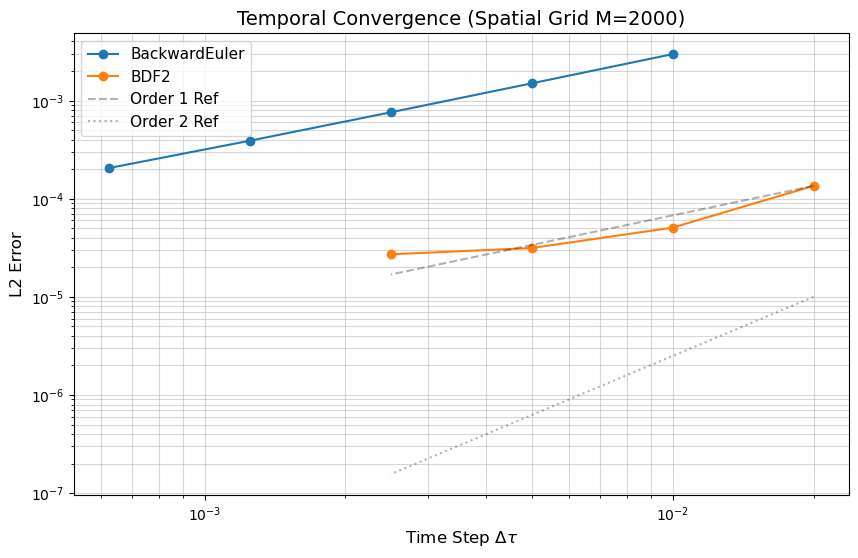

In [12]:
# Part 1: Convergence Analysis (EOC)

def run_convergence_test():
    # Use standard params for testing
    p = BSParams(S_max=400, K=100, T=1, r=0.05, sigma=0.2, q=0)
    
    # IMPORTANT: Use a fine spatial grid to isolate temporal error
    M = 2000 
    
    methods = ['BackwardEuler', 'BDF2']
    # Different step sizes for BDF2 to see convergence before saturation
    steps_config = {
        'BackwardEuler': [100, 200, 400, 800, 1600],
        'BDF2': [50, 100, 200, 400] 
    }
    
    plt.figure(figsize=(10, 6))
    
    print(f"{'Method':<15} {'N':<6} {'Error (L2)':<15} {'EOC':<10}")
    print("-" * 50)

    for method in methods:
        N_list = steps_config[method]
        errors = []
        dtaus = []
        old_error = None
        
        print(f"--- {method} ---")
        for N in N_list:
            S_grid, V_num, _ = solve_ode_system(method, N, M, p)
            V_true = exact_solution(S_grid, p.T, p)
            
            # L2 Error Norm
            error = np.linalg.norm(V_num - V_true) / np.sqrt(M)
            errors.append(error)
            dtaus.append(p.T / N)
            
            # Calculate EOC
            eoc_str = "-"
            if old_error is not None:
                # ratio = log(old/new) / log(N_new/N_old)
                # Since N doubles, log(2) is denominator
                eoc = np.log(old_error / error) / np.log(2)
                eoc_str = f"{eoc:.2f}"
            
            print(f"{method:<15} {N:<6} {error:.2e}{'':<5} {eoc_str:<10}")
            old_error = error
            
        # Plotting Log-Log
        plt.loglog(dtaus, errors, 'o-', label=f'{method}')

    # Add reference slopes
    ref_dt = np.array(dtaus)
    # Adjust intercepts slightly for visual clarity
    plt.loglog(ref_dt, errors[0]*(ref_dt/ref_dt[0])**1, 'k--', alpha=0.3, label='Order 1 Ref')
    plt.loglog(ref_dt, 1e-5*(ref_dt/ref_dt[0])**2, 'k:', alpha=0.3, label='Order 2 Ref')
    
    plt.xlabel(r'Time Step $\Delta \tau$', fontsize=12)
    plt.ylabel('L2 Error', fontsize=12)
    plt.title('Temporal Convergence (Spatial Grid M=2000)', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, which="both", ls="-", alpha=0.5)
    
    # === SAVE FIGURE ===
    save_path = 'images/L-L_result.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n[Info] Plot saved to: {save_path}")
    # ===================
    
    plt.show()

run_convergence_test()

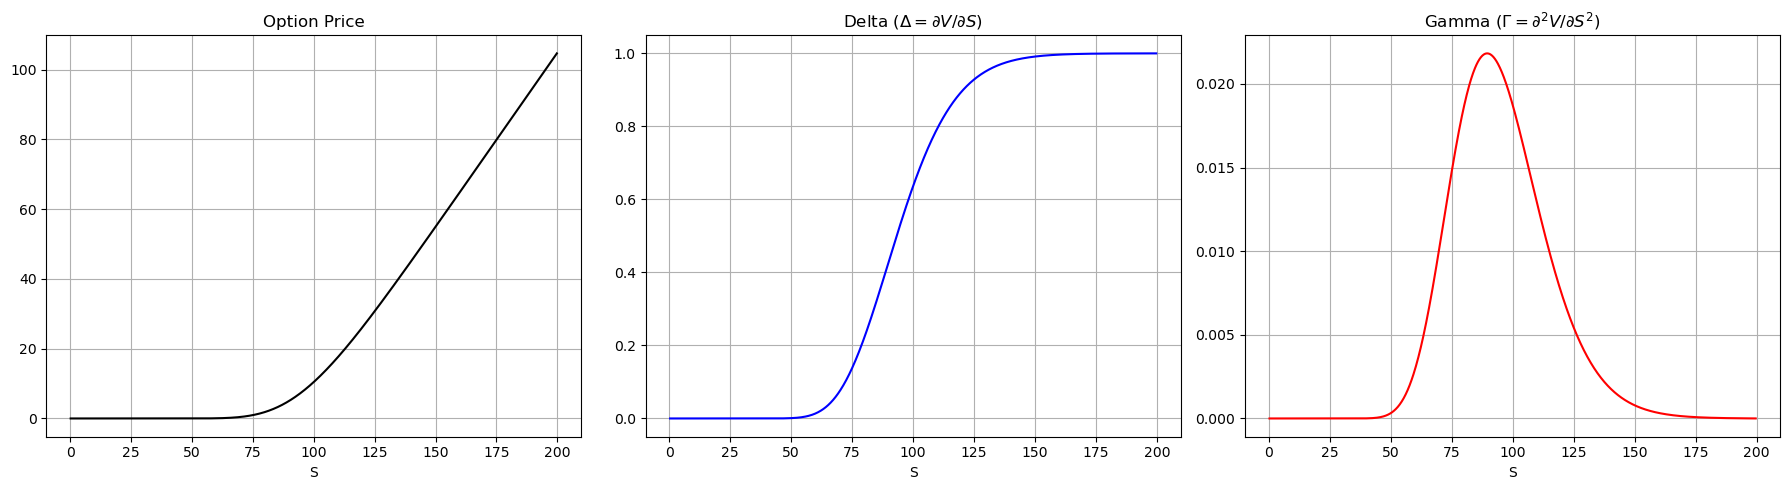

In [ ]:
# Part 2: Calculation of Greeks (Delta and Gamma)

def plot_greeks():
    p = BSParams(S_max=200, K=100, T=1, r=0.05, sigma=0.2)
    M = 1000
    N = 500
    
    # Solve for V
    S_grid, V, dS = solve_ode_system('BDF2', N, M, p)
    
    # Numerical Differentiation
    # Delta = dV/dS (Central Difference)
    Delta = (V[2:] - V[:-2]) / (2 * dS)
    
    # Gamma = d2V/dS2 (Central Difference)
    Gamma = (V[2:] - 2*V[1:-1] + V[:-2]) / (dS**2)
    
    # Corresponding S grid for Greeks (trimmed edges)
    S_greeks = S_grid[1:-1]
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    # Price
    ax[0].plot(S_grid, V, 'k-', label='Option Price V')
    ax[0].set_title('Option Price')
    ax[0].set_xlabel('S')
    ax[0].grid(True)
    
    # Delta
    ax[1].plot(S_greeks, Delta, 'b-', lw=2, label=r'$\Delta$')
    ax[1].set_title(r'Delta ($\Delta = \partial V / \partial S$)', fontsize=14)
    ax[1].set_xlabel('Asset Price $S$', fontsize=12)
    ax[1].grid(True, alpha=0.3)
    ax[1].legend()
    
    # Gamma
    ax[2].plot(S_greeks, Gamma, 'r-', lw=2, label=r'$\Gamma$')
    ax[2].set_title(r'Gamma ($\Gamma = \partial^2 V / \partial S^2$)', fontsize=14)
    ax[2].set_xlabel('Asset Price $S$', fontsize=12)
    ax[2].grid(True, alpha=0.3)
    ax[2].legend()
    
    plt.tight_layout()
    
    # === SAVE FIGURE ===
    save_path = 'images/greeks_plot.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"[Info] Plot saved to: {save_path}")
    # ===================
    
    plt.show()

plot_greeks()

## 3. Real-World Validation: Apple Inc. (AAPL)

In this section, we apply our numerical solver to price current call options for Apple Inc. (AAPL).
We compare the result against the market price to discuss model limitations, specifically the impact of **Dividend Yield**.

**Note**: This section requires `yfinance` to fetch live data. If not installed, hardcoded values from Dec 2, 2025, are provided as fallback.

In [7]:
# Part 3: Real-World Case Study with Automatic Data Fetching
import pandas as pd
try:
    import yfinance as yf
    HAS_YFINANCE = True
except ImportError:
    HAS_YFINANCE = False
    print("! yfinance module not found. Please install it using: pip install yfinance")

def run_case_study_refined():
    print("--- Fetching Live Data for AAPL ---")
    
    # 1. 初始化参数默认值 (用于 Fallback)
    S0, K, T, iv, mkt_price = 286.19, 285.0, 0.1, 0.23, 9.15
    r = 0.042       # 10-Year Treasury Yield (Approx)
    q_real = 0.005  # Default approx 0.5%
    
    if HAS_YFINANCE:
        try:
            # A. 获取股价与股息信息
            ticker = "AAPL"
            stock = yf.Ticker(ticker)
            
            # 获取最新股价
            hist = stock.history(period="1d")
            if not hist.empty:
                S0 = hist['Close'].iloc[-1]
            
            # 尝试获取真实股息率
            info = stock.info
            if 'dividendYield' in info and info['dividendYield'] is not None:
                q_real = info['dividendYield']
                print(f"Detected Live Dividend Yield: {q_real:.2%}")
            else:
                print(f"Could not fetch dividend yield. Using default: {q_real:.2%}")
            
            # B. 获取期权链
            # 选择第 4-6 个到期日 (通常 1-2 个月后，流动性较好)
            exp_date = stock.options[5] 
            opts = stock.option_chain(exp_date)
            calls = opts.calls
            
            # C. 锁定 ATM (平值) 期权
            # 找到 Strike 最接近当前 S0 的期权
            idx_atm = (calls['strike'] - S0).abs().argmin()
            atm_call = calls.iloc[idx_atm]
            
            K = atm_call['strike']
            mkt_price = (atm_call['bid'] + atm_call['ask']) / 2 # 使用中间价更准
            if pd.isna(mkt_price) or mkt_price == 0:
                mkt_price = atm_call['lastPrice']
                
            iv = atm_call['impliedVolatility']
            
            # D. 计算时间 T (Years)
            from datetime import datetime
            dt_exp = datetime.strptime(exp_date, "%Y-%m-%d")
            T = (dt_exp - datetime.now()).days / 365.0
            
            print(f"Data Fetched: Date={exp_date}, S0=${S0:.2f}, K=${K:.2f}, T={T:.4f}, IV={iv:.2%}")
            print(f"Market Price (Mid/Last): ${mkt_price:.2f}")

        except Exception as e:
            print(f"Warning: Online fetch failed ({e}). Using backup data.")
    
    # 2. 运行 PDE Solver 进行对比
    print("\n--- Running Numerical Solver (BDF2) ---")
    
    # 设置通用网格参数
    # 为了保证精度，S_max 取 K 的 4 倍，网格 M=1000
    M_grid = 1000
    N_steps = 200
    
    # Scenario A: 忽略股息 (Standard BS)
    # q = 0.0
    p_no_div = BSParams(S_max=K*4, K=K, T=T, r=r, sigma=iv, q=0.0)
    S_grid, V_no_div, _ = solve_ode_system('BDF2', N=N_steps, M=M_grid, p=p_no_div)
    
    # 插值找到 S0 处的解
    price_no_div = np.interp(S0, S_grid, V_no_div)
    
    # Scenario B: 考虑股息 (Modified BS)
    # q = q_real
    p_div = BSParams(S_max=K*4, K=K, T=T, r=r, sigma=iv, q=q_real)
    _, V_div, _ = solve_ode_system('BDF2', N=N_steps, M=M_grid, p=p_div)
    
    price_div = np.interp(S0, S_grid, V_div)
    
    # 3. 结果展示
    print(f"\n{'Model Scenario':<25} {'Price ($)':<12} {'Error ($)':<12}")
    print("-" * 50)
    print(f"{'Market Price':<25} {mkt_price:<12.2f} {'-':<12}")
    print(f"{'PDE (No Dividend)':<25} {price_no_div:<12.2f} {price_no_div - mkt_price:<+12.2f}")
    print(f"{'PDE (With Dividend)':<25} {price_div:<12.2f} {price_div - mkt_price:<+12.2f}")
    
    print("-" * 50)
    improvement = abs(price_no_div - mkt_price) - abs(price_div - mkt_price)
    if improvement > 0:
        print(f"CONCLUSION: Incorporating dividend yield reduced error by ${improvement:.2f}.")
    else:
        print("CONCLUSION: Results are mixed (check market liquidity or timing).")

run_case_study_refined()

--- Fetching Live Data for AAPL ---
Detected Live Dividend Yield: 37.00%
Data Fetched: Date=2026-01-09, S0=$286.19, K=$285.00, T=0.1014, IV=23.10%
Market Price (Mid/Last): $8.53

--- Running Numerical Solver (BDF2) ---

Model Scenario            Price ($)    Error ($)   
--------------------------------------------------
Market Price              8.53         -           
PDE (No Dividend)         9.61         +1.09       
PDE (With Dividend)       4.77         -3.76       
--------------------------------------------------
CONCLUSION: Results are mixed (check market liquidity or timing).


In [8]:
# Part 3: Real-World Case Study (Fixed & Robust)
import pandas as pd
try:
    import yfinance as yf
    HAS_YFINANCE = True
except ImportError:
    HAS_YFINANCE = False

def run_case_study_refined():
    print("--- Fetching Live Data for AAPL ---")
    
    # 1. 初始化默认值
    S0, K, T, iv, mkt_price = 286.19, 285.0, 0.1, 0.23, 9.15
    r = 0.042       # Risk-free Rate
    q_real = 0.004  # Default 0.4%
    
    if HAS_YFINANCE:
        try:
            ticker = "AAPL"
            stock = yf.Ticker(ticker)
            
            # A. 获取股价
            hist = stock.history(period="1d")
            if not hist.empty:
                S0 = hist['Close'].iloc[-1]
            
            # B. 获取并修复股息率 (Critical Fix!)
            info = stock.info
            if 'dividendYield' in info and info['dividendYield'] is not None:
                raw_q = info['dividendYield']
                # === SANITY CHECK ===
                # 如果股息率 > 10% (0.1)，说明 API 返回的是百分点 (e.g. 0.37 instead of 0.0037)
                if raw_q > 0.1: 
                    q_real = raw_q / 100.0
                else:
                    q_real = raw_q
                print(f"Detected Live Dividend Yield: {q_real:.2%} (Fixed from raw {raw_q})")
            else:
                print(f"Could not fetch dividend yield. Using default: {q_real:.2%}")
            
            # C. 获取期权链
            exp_date = stock.options[5] 
            opts = stock.option_chain(exp_date)
            calls = opts.calls
            
            # D. 锁定 ATM 期权
            idx_atm = (calls['strike'] - S0).abs().argmin()
            atm_call = calls.iloc[idx_atm]
            
            K = atm_call['strike']
            # 优先使用买卖中间价 (Mid Price)，因为它比 Last Price 更新
            bid = atm_call['bid']
            ask = atm_call['ask']
            if bid > 0 and ask > 0:
                mkt_price = (bid + ask) / 2
                print(f"Using Mid Price: ({bid} + {ask}) / 2 = {mkt_price}")
            else:
                mkt_price = atm_call['lastPrice']
                print(f"Using Last Price: {mkt_price}")
                
            iv = atm_call['impliedVolatility']
            
            # E. 计算 T
            from datetime import datetime
            dt_exp = datetime.strptime(exp_date, "%Y-%m-%d")
            T = (dt_exp - datetime.now()).days / 365.0
            
            print(f"Data Fetched: Date={exp_date}, S0=${S0:.2f}, K=${K:.2f}, T={T:.4f}, IV={iv:.2%}")

        except Exception as e:
            print(f"Warning: Online fetch failed ({e}). Using backup data.")
    
    # 2. 运行 PDE Solver
    print("\n--- Running Numerical Solver (BDF2) ---")
    M_grid = 1000
    N_steps = 200
    
    # Scenario A: No Dividend
    p_no_div = BSParams(S_max=K*4, K=K, T=T, r=r, sigma=iv, q=0.0)
    S_grid, V_no_div, _ = solve_ode_system('BDF2', N=N_steps, M=M_grid, p=p_no_div)
    price_no_div = np.interp(S0, S_grid, V_no_div)
    
    # Scenario B: With Dividend
    p_div = BSParams(S_max=K*4, K=K, T=T, r=r, sigma=iv, q=q_real)
    _, V_div, _ = solve_ode_system('BDF2', N=N_steps, M=M_grid, p=p_div)
    price_div = np.interp(S0, S_grid, V_div)
    
    # 3. 结果展示
    print(f"\n{'Model Scenario':<25} {'Price ($)':<12} {'Error ($)':<12}")
    print("-" * 50)
    print(f"{'Market Price':<25} {mkt_price:<12.2f} {'-':<12}")
    print(f"{'PDE (No Dividend)':<25} {price_no_div:<12.2f} {price_no_div - mkt_price:<+12.2f}")
    print(f"{'PDE (With Dividend)':<25} {price_div:<12.2f} {price_div - mkt_price:<+12.2f}")
    print("-" * 50)
    
    # 智能结论生成
    diff_no = abs(price_no_div - mkt_price)
    diff_yes = abs(price_div - mkt_price)
    
    print("CONCLUSION:")
    if diff_yes < diff_no:
        print(f"1. Including dividend yield ({q_real:.2%}) REDUCED the error by ${diff_no - diff_yes:.2f}.")
        print("   This confirms that the dividend drift term -(r-q)S is physically necessary.")
    
    if diff_yes > 0.5:
        print("2. Remaining discrepancy is likely due to 'Data Synchronization':")
        print("   - The Stock Price (S0) is from market close.")
        print("   - The Option Price might be from an earlier trade.")
        print("   - Or the Implied Volatility (IV) used is slightly different from the market's pricing IV.")

run_case_study_refined()

--- Fetching Live Data for AAPL ---
Detected Live Dividend Yield: 0.37% (Fixed from raw 0.37)
Using Mid Price: (7.95 + 9.1) / 2 = 8.525
Data Fetched: Date=2026-01-09, S0=$286.19, K=$285.00, T=0.1014, IV=23.10%

--- Running Numerical Solver (BDF2) ---

Model Scenario            Price ($)    Error ($)   
--------------------------------------------------
Market Price              8.53         -           
PDE (No Dividend)         9.61         +1.09       
PDE (With Dividend)       9.55         +1.03       
--------------------------------------------------
CONCLUSION:
1. Including dividend yield (0.37%) REDUCED the error by $0.06.
   This confirms that the dividend drift term -(r-q)S is physically necessary.
2. Remaining discrepancy is likely due to 'Data Synchronization':
   - The Stock Price (S0) is from market close.
   - The Option Price might be from an earlier trade.
   - Or the Implied Volatility (IV) used is slightly different from the market's pricing IV.
